# Linformer - a practical way to scale transformers efficiently

In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import math
import time
import torch.nn.functional as F
import tiktoken

In [2]:
# Setting up device configurations
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is: ", device)

Device is:  cuda


In [3]:
tokenizer = tiktoken.get_encoding("gpt2") # Load the GPT-2 tokenizer

In [4]:
# Downloading the Data -> Here we are using songs dataset 
!wget https://github.com/Deevanshik/Linformer/blob/main/Data/data.txt
with open('/kaggle/working/data.txt', 'r', encoding='utf-8') as f:
    text = f.read()

--2025-06-01 19:05:49--  https://github.com/Deevanshik/Linformer/blob/main/Data/data.txt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data.txt’

data.txt                [ <=>                ]   1.09M  --.-KB/s    in 0.08s   

2025-06-01 19:05:50 (14.2 MB/s) - ‘data.txt’ saved [1139927]



In [5]:
data = torch.tensor(tokenizer.encode(text), dtype = torch.int64)
print(data.shape, data.dtype)
print(data[:10])

# Train and Validation Split
n = int(0.9*(len(data)))
train_data = data[:n]
val_data = data[n:]
vocab_size = tokenizer.n_vocab

torch.Size([344704]) torch.int64
tensor([  628,   628,   198,   198,    27,     0, 18227,  4177,    56, 11401])


In [6]:
# Setting up model configuration
LINFORMER_CONFIG = {
    "vocab_size": vocab_size,    # Vocabulary size
    "context_length": 512, # Context length
    "emb_dim": 384,         # Embedding dimension
    "proj_dim" : 64,     # Projected sequence length
    "n_heads": 6,          # Number of attention heads
    "n_layers": 6,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False,       # Query-Key-Value bias
    "use_mask" : True,
    "batch_size": 16,
    "n_epochs":1,
    "train_data_size":len(train_data),
    "lr": 10**-5,
    "sharing": "layerwise-sharing"
}

In [7]:
# Embedding class
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_size, max_seq_length, padding_idx):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.pos_embed = nn.Embedding(max_seq_length, embed_size)

    def forward(self, x):
        B, T = x.shape
        emb = self.embed(x)  # (B, T, C)
        positions = torch.arange(T, device=device)
        pos_emb = self.pos_embed(positions).unsqueeze(0).expand(B,T, -1) # (B, T, C)
        # Creating a padding mask to set padding tokens to all zero
        padding_mask = (x == self.embed.padding_idx).unsqueeze(-1)  # (B, T, 1)
        pos_emb = pos_emb.masked_fill(padding_mask, 0)
        return emb+pos_emb

In [8]:
def generate_causal_mask(seq_length, proj_dim):
    mask = torch.tril(torch.ones(seq_length, proj_dim, dtype=torch.int))
    return mask.unsqueeze(0).unsqueeze(0)

In [9]:
def generate_padding_mask(context_length, seq_length, proj_dim):
    # Create a mask of zeros
    mask = torch.zeros(context_length, proj_dim, dtype=torch.int)
    
    # Set first `seq_length` rows to 1
    mask[:seq_length, :] = 1
    
    return mask.unsqueeze(0).unsqueeze(0)

In [10]:
# 3. Multi-Head Attention 
class MultiHeadLinearAttention(nn.Module):
    def __init__(self, embed_size, num_heads, proj_dim, seq_len, sharing, proj, qkv_bias=False, layer_idx=None):
        super().__init__()
        self.embed_size = embed_size # -> d
        self.num_heads = num_heads # -> h
        self.head_dim = embed_size // num_heads # -> d/h
        self.proj_dim = proj_dim  # -> k
        self.seq_len = seq_len # -> N
        self.sharing = sharing
        self.layer_idx = layer_idx
        self.proj = proj
        
        self.query = nn.Linear(embed_size, embed_size, bias=qkv_bias) # d*d
        self.key = nn.Linear(embed_size, embed_size, bias=qkv_bias) # d*d
        self.value = nn.Linear(embed_size, embed_size, bias=qkv_bias) # d*d
        
        self.out = nn.Linear(embed_size, embed_size) # fully connected FFNN from d -> d
        
    def forward(self, x, use_mask=False):
        B, T, _ = x.shape # Batch size, Sequence Length, Embed size
        h = self.num_heads
        d_h = self.head_dim
        N = self.seq_len
        
        q = self.query(x).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2) # (B, N, d) → (B, N, h, d/h) -> (B, h, N, d/h)
        k = self.key(x).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.value(x).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        

        if(self.sharing == "layerwise-sharing"):
            # layerwise sharing 
            projn_matrix = self.proj
            projn_matrix = projn_matrix.unsqueeze(0).unsqueeze(0).transpose(-1,-2)
            k_proj = projn_matrix@k
            v_proj = projn_matrix@v
        elif(self.sharing == "key-value-sharing"):
            # key-value sharing
            projn_matrix = self.proj[self.layer_idx]
            projn_matrix = projn_matrix.unsqueeze(0).unsqueeze(0).transpose(-1,-2)
            k_proj = projn_matrix@k
            v_proj = projn_matrix@v
        elif(self.sharing == "headwise-sharing"):
            # headwise sharing
            projn_matrix_E = self.proj["E"][self.layer_idx]
            projn_matrix_F = self.proj["F"][self.layer_idx]
            projn_matrix_E = projn_matrix_E.unsqueeze(0).unsqueeze(0).transpose(-1,-2)
            projn_matrix_F = projn_matrix_F.unsqueeze(0).unsqueeze(0).transpose(-1,-2)
            k_proj = projn_matrix_E@k
            v_proj = projn_matrix_F@v
        elif(self.sharing == None):
            k_proj = k
            v_proj = v
            
        attention = (q@(k_proj.transpose(-1, -2))) / math.sqrt(self.head_dim) # (B, h, N, k)
        if (use_mask):
            if(self.sharing == None):
                causal_mask = generate_causal_mask(T, T) # (1,1,T,T)
                padding_mask = generate_padding_mask(self.seq_len, T, T) # (1,1,T,T)
            else:
                causal_mask = generate_causal_mask(T, self.proj_dim) # (1,1,T,k)
                padding_mask = generate_padding_mask(self.seq_len, T, self.proj_dim) # (1,1,T,k)
            mask = causal_mask&padding_mask
            mask = mask.to(device)
            attention = attention.masked_fill(mask == 0, float('-inf'))
        attention = torch.softmax(attention, dim=-1)
        attention = torch.nan_to_num(attention, nan=0.0) # (B,h,N,k)
        
        out = attention@v_proj
        out = out.transpose(1, 2).contiguous().view(B, -1, self.embed_size)
        return self.out(out)

In [11]:
# 5. Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, embed_size, ff_hidden_size):
        super().__init__()
        # First linear layer that transforms input from embedding size to hidden size
        self.fc1 = nn.Linear(embed_size, ff_hidden_size)
        # Second linear layer that transforms from hidden size back to embedding size
        self.fc2 = nn.Linear(ff_hidden_size, embed_size)
        # GELU activation function
        self.gelu = nn.GELU()
    def forward(self, x):
        # Forward pass: apply the first linear layer, then GELU activation, and finally the second linear layer
        return self.fc2(self.gelu(self.fc1(x)))

In [12]:
def projection(sharing, seq_length, proj_dim, n_layers=None, device=None):
    if sharing == "layerwise-sharing":
        proj = nn.Parameter(torch.empty(seq_length, proj_dim).to(device))
        torch.nn.init.xavier_normal_(proj)
        return proj

    elif sharing == "key-value-sharing":
        proj = [nn.Parameter(torch.empty(seq_length, proj_dim).to(device)) for _ in range(n_layers)]
        for proj_i in proj:
            torch.nn.init.xavier_normal_(proj_i)
        return proj

    elif sharing == "headwise-sharing":
        E_proj = [nn.Parameter(torch.empty(seq_length, proj_dim).to(device)) for _ in range(n_layers)]
        F_proj = [nn.Parameter(torch.empty(seq_length, proj_dim).to(device)) for _ in range(n_layers)]
        for proj_i in E_proj:
            torch.nn.init.xavier_normal_(proj_i)
        for proj_i in F_proj:
            torch.nn.init.xavier_normal_(proj_i)
        proj_dict = {
            "E": E_proj,
            "F": F_proj
        }
        return proj_dict

In [13]:
# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads, ff_hidden_size, proj_dim, seq_len, sharing, proj, dropout=0.1, qkv_bias=False, layer_idx=None):
        super().__init__()
        # Layer norm before attention
        self.ln1 = nn.LayerNorm(embed_size)
        # Multi-Head Self-Attention
        self.mha = MultiHeadLinearAttention(embed_size, num_heads, proj_dim, seq_len, sharing, proj, qkv_bias=qkv_bias, layer_idx=layer_idx)
        self.dropout1 = nn.Dropout(dropout)

        # Layer norm before FFN
        self.ln2 = nn.LayerNorm(embed_size)
        self.ff = FeedForward(embed_size, ff_hidden_size)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, use_mask=False):
        # MHA with Layer norm and residual connection
        x = x + self.dropout1(self.mha(self.ln1(x), use_mask))
        # FFN with layer norm and residual connection
        x = x + self.dropout2(self.ff(self.ln2(x)))
        return x

In [14]:
def right_pad_input(input_ids, context_length, pad_token_id=-1):
    B,T = input_ids.shape
    if T < context_length:
        padding = torch.full((B, context_length - T), pad_token_id, dtype=input_ids.dtype, device=input_ids.device)
        input_ids_padded = torch.cat([input_ids, padding], dim=1)
    else:
        input_ids_padded = input_ids[:, :context_length]
    return input_ids_padded

In [15]:
# 7. Linformer Model
class Linformer(nn.Module):
    def __init__(self, config, seq_len):
        super().__init__()
        # Initializing embedding layer that converts token ids to embeddings
        self.embedding = Embedding(config["vocab_size"]+1, config["emb_dim"], config["context_length"], padding_idx=config["vocab_size"])
        
        # Create a list of transformer blocks
        if(config["sharing"] == "layerwise-sharing"):
            # Only 1 projection matrix
            proj = projection(config["sharing"], seq_len, config["proj_dim"], device=device)
            self.transformer_blocks = nn.ModuleList([
                TransformerBlock(config["emb_dim"], config["n_heads"], config["emb_dim"] * 4, config["proj_dim"], seq_len, config["sharing"], proj, config["drop_rate"], config["qkv_bias"])
                for _ in range(config["n_layers"])  # Repeat for num_layers 
            ])
        
        elif(config["sharing"] == "key-value-sharing"):
            # No. of projection matrices = config["n_layers"]
            proj = projection(config["sharing"], seq_len, config["proj_dim"], n_layers=config["n_layers"], device=device)
            self.transformer_blocks = nn.ModuleList([
                TransformerBlock(config["emb_dim"], config["n_heads"], config["emb_dim"] * 4, config["proj_dim"], seq_len, config["sharing"], proj, config["drop_rate"], config["qkv_bias"], layer_idx=i)
                for i in range(config["n_layers"])  # Repeat for num_layers 
            ])
            
        elif(config["sharing"] == "headwise-sharing"):
            # No. of projection matrices = 2*config["n_layers"]
            proj = projection(config["sharing"], seq_len, config["proj_dim"], n_layers=config["n_layers"], device=device)
            self.transformer_blocks = nn.ModuleList([
                TransformerBlock(config["emb_dim"], config["n_heads"], config["emb_dim"] * 4, config["proj_dim"], seq_len, config["sharing"], proj, config["drop_rate"], config["qkv_bias"], layer_idx)
                for layer_idx in range(config["n_layers"])  # Repeat for num_layers 
            ])
        elif(config["sharing"] == None): # Vanilla Transformer
            proj = None
            self.transformer_blocks = nn.ModuleList([
                TransformerBlock(config["emb_dim"], config["n_heads"], config["emb_dim"] * 4, config["proj_dim"], seq_len, config["sharing"], proj, config["drop_rate"], config["qkv_bias"], layer_idx)
                for layer_idx in range(config["n_layers"])  # Repeat for num_layers 
            ])

        # Final linear layer to project the output back to the vocabulary size for logits
        self.fc_out = nn.Linear(config["emb_dim"], config["vocab_size"])
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(config["drop_rate"])
        
    def forward(self, x, targets=None, use_mask=False, pad_token_id=vocab_size):
        # Step 1: Convert input token IDs to embeddings and add positional encodings
        x = self.dropout(self.embedding(x))
        
        # Step 2: Pass the embeddings through each transformer block
        for block in self.transformer_blocks:
            x = block(x, use_mask)  # Apply the transformer block with optional masking
        
        # Step 3: Calculate the logits
        logits = self.fc_out(x)  # Shape: (batch_size, seq_length, vocab_size)

        # Step 4: Calculating the loss
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=pad_token_id)

        return logits, loss

    def generate(self, input_text, max_new_tokens, context_length, vocab_size, use_mask=False, pad_token_id=vocab_size):
        # Converts input_text-> string array
        x = tokenizer.encode(input_text) # list of length T, T is no. of tokens
        x = torch.tensor(x).unsqueeze(0).to(device)
        T = x.shape[1]
        x = right_pad_input(x, context_length=context_length, pad_token_id = pad_token_id)
        with torch.no_grad():
            for i in range(max_new_tokens):
                # Get the predictions
                logits, loss = self(x, use_mask=use_mask, pad_token_id=pad_token_id) # (B, T, C)
            
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
            
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
            
                # sample from the distribution
                x_next = torch.multinomial(probs, num_samples=1) # (B, 1)
                if(T < context_length):
                    x[0][T] = x_next[0].item()
                else:
                    x = x[:, 1:]
                    x = torch.cat((x, x_next), dim=1)

                input_text += tokenizer.decode([x_next[0].item()])
                T = T+1

        return input_text

---

# Training

In [16]:
# Generating the batch
def get_batch(split, batch_size, seq_length): # Gives us batches on the bases of split
    data = train_data if split == "train" else val_data
    index = torch.randint(len(data) - seq_length, (batch_size,)) 
    # gives us list of random integers between range [0, len(data)-seq_length] of length equal to batch size
    x = torch.stack([data[i:i+seq_length] for i in index])
    y = torch.stack([data[i+1:i+seq_length+1] for i in index])
    x, y = x.to(device), y.to(device)
    return x, y

In [17]:
# Linear Attention
m = Linformer(LINFORMER_CONFIG, LINFORMER_CONFIG["context_length"])
model = m.to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=LINFORMER_CONFIG["lr"],
                             betas=(0.9, 0.95), 
                             weight_decay=0.01)

In [18]:
# Learning rate scheduler

def get_lr(it):
    if it < warmup_iters:
        # Linear warmup from min_lr -> max_lr
        return min_lr + (max_lr - min_lr) * (it / warmup_iters)
    elif it <= n_iters:
        # Cosine decay from max_lr -> min_lr
        decay_iters = n_iters - warmup_iters
        it_decay = it - warmup_iters
        cosine_decay = 0.5 * (1 + math.cos(math.pi * it_decay / decay_iters))
        return min_lr + (max_lr - min_lr) * cosine_decay
    else:
        # After training iterations, return min_lr
        return min_lr


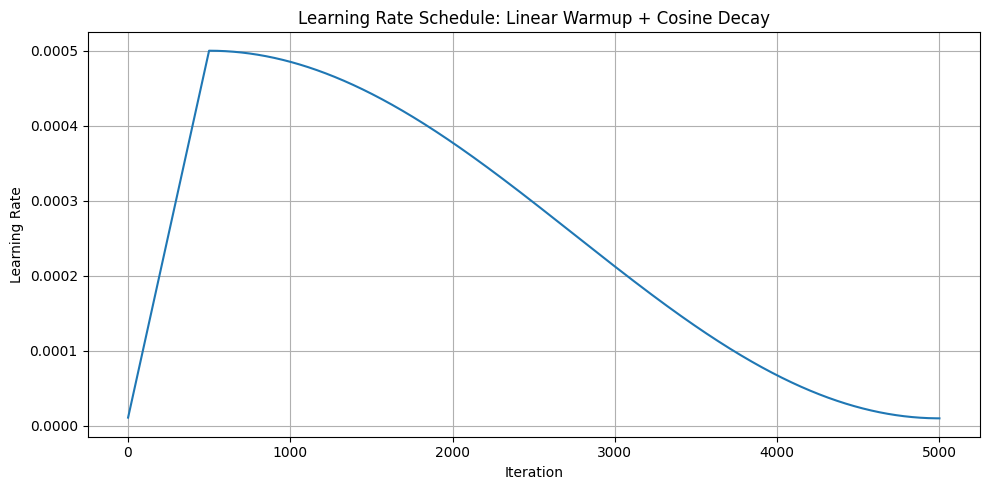

In [19]:
# Example
import matplotlib.pyplot as plt

# Scheduler configuration
n_iters = 5000
warmup_iters = 500
min_lr = 1e-5
max_lr = 5e-4

# Learning rate scheduler function
def get_lr(it):
    if it < warmup_iters:
        return min_lr + (max_lr - min_lr) * (it / warmup_iters)
    elif it <= n_iters:
        decay_iters = n_iters - warmup_iters
        it_decay = it - warmup_iters
        cosine_decay = 0.5 * (1 + math.cos(math.pi * it_decay / decay_iters))
        return min_lr + (max_lr - min_lr) * cosine_decay
    else:
        return min_lr

# Generate learning rate values
lr_values = [get_lr(it) for it in range(1, n_iters + 1)]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_iters + 1), lr_values)
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule: Linear Warmup + Cosine Decay")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# Training the model
n_iters = 5000
vocab_size = LINFORMER_CONFIG["vocab_size"]
warmup_iters = 0.05*n_iters # 5% of total iterations
min_lr = LINFORMER_CONFIG["lr"]
max_lr = LINFORMER_CONFIG["lr"]*50
step = n_iters/10
loss_list = []
start_time = time.time()  # Start timer
for iteration in range(1, n_iters + 1):
    lr = get_lr(iteration)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    xb, yb = get_batch('train', LINFORMER_CONFIG["batch_size"], LINFORMER_CONFIG["context_length"])
    logits, loss = model(x=xb, targets=yb, use_mask=LINFORMER_CONFIG["use_mask"], pad_token_id=vocab_size)
    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if iteration % step == 0:
        print(f"Iteration {iteration}/{n_iters} | Loss: {loss.item():.4f}")

print("-----------------Training complete------------------")

end_time = time.time()  # End timer
total_time = end_time - start_time
print(f"Total Training Time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")

Iteration 500/5000 | Loss: 3.0502
Iteration 1000/5000 | Loss: 2.1735
Iteration 1500/5000 | Loss: 1.7160
Iteration 2000/5000 | Loss: 1.3382
Iteration 2500/5000 | Loss: 1.2803
Iteration 3000/5000 | Loss: 0.9538
Iteration 3500/5000 | Loss: 0.9831
Iteration 4000/5000 | Loss: 0.8640
Iteration 4500/5000 | Loss: 0.7827
Iteration 5000/5000 | Loss: 0.8213
-----------------Training complete------------------
Total Training Time: 1369.52 seconds (22.83 minutes)


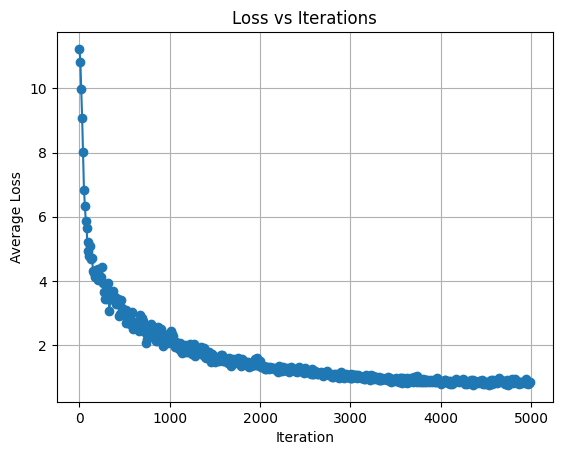

In [24]:
interval = 10
iterations = list(range(1, n_iters + 1))[::interval]
loss_subset = loss_list[::interval]

plt.plot(iterations, loss_subset, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Average Loss")
plt.title("Loss vs Iterations")
plt.grid(True)
plt.savefig("loss_curve.png", dpi=300)
plt.show()

In [26]:
# Generating an output
input_text = "He said the way my blue eyes shined"
output = model.generate(input_text=input_text,
               max_new_tokens=50, 
               context_length=LINFORMER_CONFIG["context_length"], 
               vocab_size=vocab_size,
               use_mask=True,
               pad_token_id=vocab_size)
print(output)

He said the way my blue eyes shinedhe they in love You Ied toSt hundred otherThen hold yeah no through"," to"," please grow375toOur listen, yours a a that"," are am land place sleep score black get orSt am maybe keep with woman327 didn66 hurt
